# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 10 декабря 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 10 декабря, -4 балла после 06:00 17 декабря, -6 баллов после 06:00 24 декабря -8 баллов  после 06:00 31 декабря

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 4] Фамилия Имя

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [1]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



Функционал качества

$$Q = \sum_{n}^{N} r_{n, k} ||x_n - \mu_n||^{2} $$

где $\mu_n$ - центр кластера, к которому принадлежит $x_n$ 

На E-шаге функционал не возрастает, на M-шаге, очевидно, тоже. Так как последовательность функционалов ограничена снизу хотя бы нулём, она сходится.

При этом, если на E-шаге в какой-то момент функционал не уменьшился (разбиение не поменялось), то все последующие функционалы равны ему и мы говорим, что алгоритм сошелся.

Всего разбиений $k^{N}$, какое-то из них минимизирует функционал. Следовательно, минимум функционала мы найдем менее чем за $k^{N}$ шагов.

Задача 2.  ММП для многомерного нормального распределения.

Функция правдоподобия в общем случае записывается как:
￼
￼$$ L(\theta) = p(X | \theta ) = \prod_{i=1}^N p(x_i | \theta)$$

Для многомерного нормального распределения плотность вероятности:
$$p(x_i| \theta) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}e^{-\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)}$$

Выведите ММП оценку для вектора $\mu$
￼

Перейдём к логарифмам:

$$L1(\theta) = \sum_{i = 1}^{n} \ln(\frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}e^{-\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)}) $$

$$ L1(\theta) = -\frac{1}{2} \ln(\frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}) \sum_{i = 1}^{n}(x_i - \mu)^T\Sigma^{-1}(x_i - \mu)$$

Так как нас интересует оценка для $\mu$, дифференцируем по $\mu$

$$L1'_{\mu}(\theta) = \frac{1}{2} \ln(\frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}) * (\Sigma^{-1} + (\Sigma^{-1})^{T}) \sum_{i = 1}^{n} (x_i - \mu)$$

$$L1'_{\mu}(\theta) = 0 \iff \mu = \frac{1}{n}\sum_{i=1}^{n} x_i $$

Следовательно, функция правдоподобия максимизируется, когда $\mu = \frac{1}{n}\sum_{i=1}^{n} x_i $

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




Возможно два случая:

$d_{\min}(U \cup V, S) = d_{\min}(U, S) $ или $d_{\min}(U \cup V, S) = d_{\min}(V, S) $

Следовательно:

$d_{\min}(U, S) \leq d_{\min}(V, S)$ или $d_{\min}(U, S) > d_{\min}(V, S)$ соответственно

Раскроем модуль и получим нужное нам выражение

Аналогично для $max$

# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [2]:
from sklearn.base import BaseEstimator, ClusterMixin
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

class Clustering(BaseEstimator, ClusterMixin):
    """
    Agglomerative clustering algorythm 
    """
    
    def __init__(self, n_clusters, linkage='average', metric='euclidean'):
        self.linkage = linkage
        self.n_clusters = n_clusters
        self.metric = metric
        if linkage == 'simple':
            self.linkage_func = self.simple_linkage
        elif linkage == 'complete':
            self.linkage_func = self.complete_linkage
        elif linkage == 'average':
            self.linkage_func = self.average_linkage
        else:
            print('incorrect name of linkage')
            raise KeyError(linkage)
    
    def simple_linkage(self, i_row, j_row, i_c, j_c):
        return 0.5 * i_row + 0.5 * j_row - 0.5 * np.absolute(i_row - j_row)
    
    def complete_linkage(self, i_row, j_row, i_c, j_c):
        return 0.5 * i_row + 0.5 * j_row + 0.5 * np.absolute(i_row - j_row)
    
    def average_linkage(self, i_row, j_row, i_c, j_c):
        return (i_c/(i_c + j_c)) * i_row + (j_c/(i_c + j_c)) * j_row
        
    def fit_predict(self, x):
        self.x_len = len(x)
        clusters_count = [1] * self.x_len
        preds = np.array(range(self.x_len))
        x = np.array(x)
        cur_clusters = self.x_len
        dist = pdist(x, self.metric)
        self.dist = dist
        dist = squareform(dist)
        dist = np.array(dist)
        np.fill_diagonal(dist, np.inf)
        while (cur_clusters > self.n_clusters):
            i, j = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
            i_c = clusters_count[i]
            j_c = clusters_count[j]
            i_row = dist[i]
            i_row = np.delete(i_row, [i, j])
            j_row = dist[j]
            j_row = np.delete(j_row, [i, j])
            dist = np.delete(dist, [i, j], 0)
            dist = np.delete(dist, [i, j], 1)
            cur_clusters -= 1
            new_row = self.linkage_func(i_row, j_row, i_c, j_c)
            dist = np.vstack((dist, new_row))
            new_col = np.append(new_row, np.inf).reshape(-1, 1)
            dist = np.hstack((dist, new_col))
            clusters_count = np.delete(clusters_count, [i, j])
            clusters_count = np.append(clusters_count, [i_c + j_c])
            wheri = np.where(preds == i)
            wherj = np.where(preds == j)
            wher1 = np.where(((preds > i) & (preds < j)) | ((preds < i) & (preds > j)))
            wher2 = np.where((preds > i) & (preds > j))
            preds[wheri] = clusters_count.size - 1
            preds[wherj] = clusters_count.size - 1
            preds[wher1] -= 1
            preds[wher2] -= 2
        return preds
    
    def plot_dendrogram(self):
        z = linkage(self.dist, self.linkage)
        plt.figure(figsize=(25, 10))
        dn = dendrogram(z)
        plt.show()

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

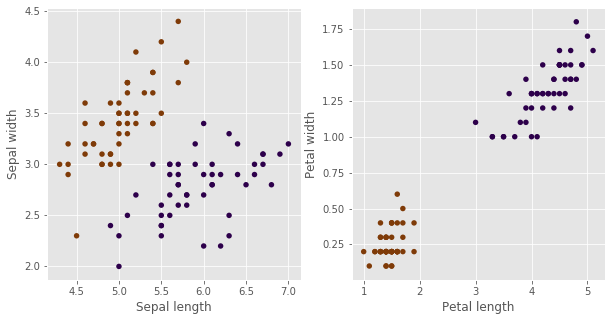

In [3]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [4]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print (" Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))

 Sklearn AGGL score 1.0. Sklearn AGGL time 0.0007541179656982422


Our AGGL score 1.0. Our AGGL time 0.022905826568603516


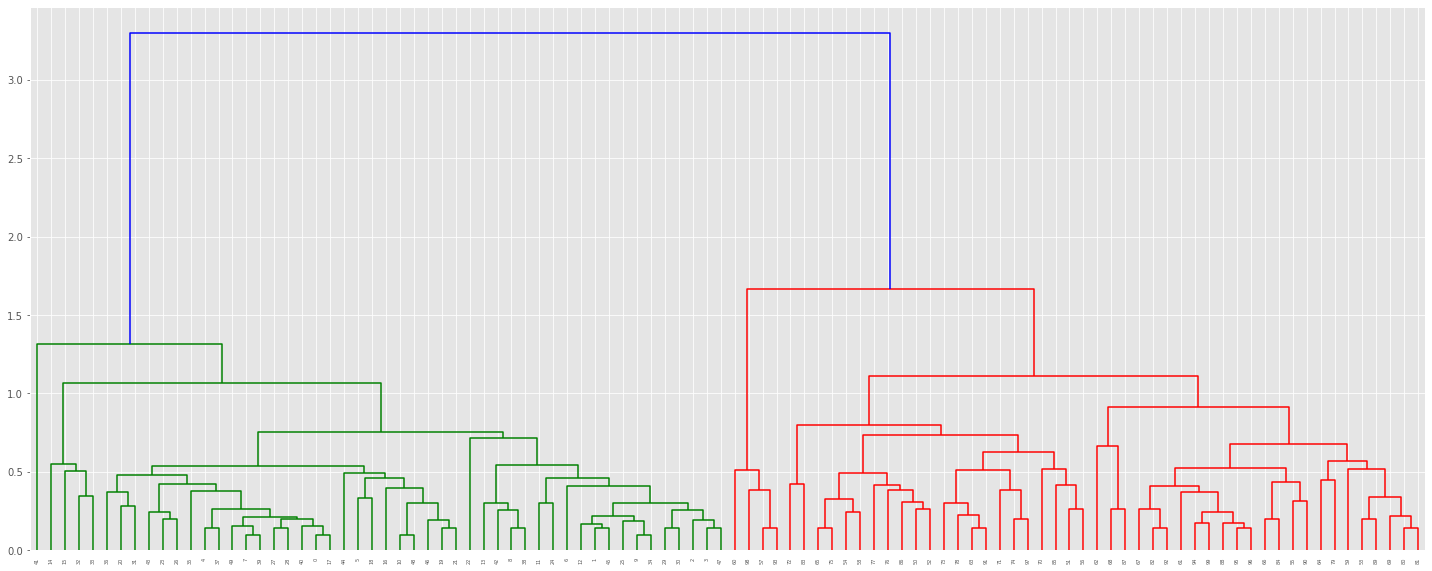

In [5]:
# Здесь предскажем кластера, посчитаем метрику кластеризации и время работы, сравним со склерном
сustum_aggl = Clustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))
сustum_aggl.plot_dendrogram()

# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?
* Да, посмотреть, какие кластеры, состоящие из одного объекта, объединились с другими последними

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? 
* Ответ ниже

3) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)
* Ответ ниже

4) Как можно результат кластеризации затем использовать для  финальной модели обучения с учителем?
* Смотреть на выбросы, а если получится хороший скор на трейне, то можно попробовать в лоб использовать кластеризацию на тесте

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках.

In [6]:
doc_to_title = {}
with open('../project/anomaly-detection-competition-ml1-ts-fall-2019/docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [7]:
train_data = pd.read_csv('../project/anomaly-detection-competition-ml1-ts-fall-2019/train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять, например, словами из тайтла.

Главное подобрать хорошую функцию расстояния между документами


Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

In [8]:
docs_titles = pd.read_csv('../project/anomaly-detection-competition-ml1-ts-fall-2019/docs_titles.tsv', sep='\t', encoding='utf-8', lineterminator='\n')

In [9]:
train_groups = pd.read_csv('../project/anomaly-detection-competition-ml1-ts-fall-2019/train_groups.csv')

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, HashingVectorizer
import pymorphy2 as pm
from multiprocessing import Pool, Lock, Value

In [11]:
ma = pm.MorphAnalyzer()
docs_titles['title'] = docs_titles['title'].astype(str)
docs_titles['title'] = [text.lower() for text in docs_titles['title']]
docs_titles['title'] = [re.sub('[^0-9a-zA-ZА-Яа-я]+', ' ', text) for text in docs_titles['title']]
def norm(text):
    res = ''
    for word in text.split():
        if word != '':
            t = ma.parse(word)[0].normal_form
            res = res + t
            res = res + ' '
    return res

with Pool(10) as pool:
    docs_titles['title'] = list(pool.map(norm, docs_titles['title']))

In [12]:
%%time
groups_train = []
target_groups = []
for group_id in range(1, 130):
    part = train_groups[train_groups.group_id == group_id]
    arr = []
    arr_t = []
    for doc_id in part['doc_id']:
        arr.append(docs_titles[docs_titles.doc_id == doc_id].iloc[0]['title'])
        arr_t.append(part[part.doc_id == doc_id].iloc[0]['target'])
    groups_train.append(arr)
    target_groups.append(arr_t)
groups_train[0]

CPU times: user 16.1 s, sys: 33.4 ms, total: 16.2 s
Wall time: 16.2 s


['ваза 21213 замена подшипник ступица нива ',
 'ваза 2107 оптом в сочи сравнить цена купить потребительский товар на tiu ru ',
 'купить ступица лада калина2 трансмиссия переходный ступица цена замена тюнинг ',
 'классика 21010 21074 ',
 'ступица нива замена подшипник свой рука ',
 'ваза 2110 ',
 'обзор подшипник полуось ваза 2101 07 2121 2123 ',
 'купить подшипник и ступица fag страница 23 ',
 'horsepowers автомобильный интернет портал отзыв владелец ваза 2121 нива 2007 год ',
 'новость и сообщение из официальный группа вконтакте торговый компания 33 sport магазин тольятти ',
 'инструкция по замена подшипник передний ступица ивеко дейли через dorognoekam ru ',
 'ступица olx ua страница 80 ',
 'маааленький проблёмкий бортжурнал автокам 2160 1994 год на drive2 ',
 'разгрузить полуось для нива 24 шлиц 765 мм ',
 'прошивка для нива м7 9 7 скачать файлообменник emqraty6 foxkirov ru ',
 'страница 6 раздел каталог подвеска ',
 'продать нива 2121 ',
 'рекомендация по проведение независимый экс

In [13]:
cv = CountVectorizer(min_df=2, max_df=0.8)
tf = TfidfTransformer()
matrix_train = []
for group in groups_train:
    m = cv.fit_transform(group).toarray()
    matrix_train.append(tf.fit_transform(m).toarray())

In [14]:
from sklearn.metrics import f1_score
all_targ = np.array(train_groups['target'])

In [15]:
scores = []
preds = []
score_to_metric = {}
for metric in ['minkowski', 'seuclidean', 'sqeuclidean', 'cosine', 'cityblock', 'euclidean', 'hamming', 'jaccard', 'braycurtis', 'canberra', 'chebyshev', ]:
    for linkage in ['simple', 'complete', 'average']:
        y_pred = []
        for m in matrix_train:
            cl = Clustering(n_clusters=2, linkage=linkage, metric=metric)
            y = cl.fit_predict(m)
            y = list(y)
            y_pred += y
        score = f1_score(y_pred, all_targ)
        scores.append(score)
        score_to_metric[metric] = np.mean(scores[-3::])
        preds.append(y_pred)
        print('DONE FOR METRIC = {} LINKAGE = {}, SCORE = {}'.format(metric, linkage, score))

DONE FOR METRIC = minkowski LINKAGE = simple, SCORE = 0.3979065203169296
DONE FOR METRIC = minkowski LINKAGE = complete, SCORE = 0.38989587350559196
DONE FOR METRIC = minkowski LINKAGE = average, SCORE = 0.4379391100702576
DONE FOR METRIC = seuclidean LINKAGE = simple, SCORE = 0.42539946046897703
DONE FOR METRIC = seuclidean LINKAGE = complete, SCORE = 0.43227786302134186
DONE FOR METRIC = seuclidean LINKAGE = average, SCORE = 0.4371606948968513
DONE FOR METRIC = sqeuclidean LINKAGE = simple, SCORE = 0.4427833650448492
DONE FOR METRIC = sqeuclidean LINKAGE = complete, SCORE = 0.3640427599611273
DONE FOR METRIC = sqeuclidean LINKAGE = average, SCORE = 0.43262264541502793
DONE FOR METRIC = cosine LINKAGE = simple, SCORE = 0.45827791079187735
DONE FOR METRIC = cosine LINKAGE = complete, SCORE = 0.42751031636863823
DONE FOR METRIC = cosine LINKAGE = average, SCORE = 0.4539767649687221
DONE FOR METRIC = cityblock LINKAGE = simple, SCORE = 0.4448509485094851
DONE FOR METRIC = cityblock LINKA

In [16]:
score_to_metric

{'minkowski': 0.4085805012975931,
 'seuclidean': 0.4316126727957234,
 'sqeuclidean': 0.4131495901403348,
 'cosine': 0.44658833070974585,
 'cityblock': 0.4289819960444148,
 'euclidean': 0.40941091122981427,
 'hamming': 0.427275503167646,
 'jaccard': 0.38692977647847004,
 'braycurtis': 0.43390529768095926,
 'canberra': 0.4319967817910173,
 'chebyshev': 0.4272879250915949}

In [17]:
np.max(scores)

0.4627714995591889

То есть, в среднем, лучшее расстояние - косинусное, но лучший скор получили с braycurtis и average linkage

Если получилось найти выбросы с помощью кластеризации, то не забывайте использовать его в финальном решении. Помните - использование различных подходов к решению задачи всегда улучшает финального качество.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***

Всё отлично, всё нравится, в восторге.